## Data Analysis

(1, 128, 128)


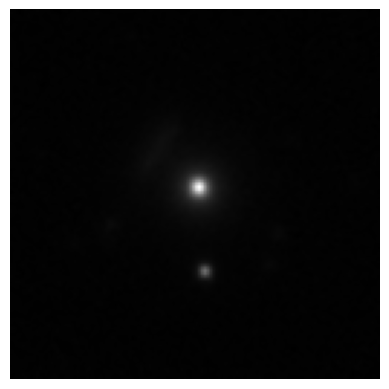

In [25]:
import numpy as np
import matplotlib.pyplot as plt

## HR

# Load the image
img = np.load("/kaggle/input/gsoc-dataset-3b/Dataset/HR/HR_127.npy")
print(img.shape)
# Convert from (C, H, W) to (H, W, C)
img = np.transpose(img, (1, 2, 0))  


# Display the image
plt.imshow(img, cmap="gray")  # Use cmap="gray" if it's a grayscale image
plt.axis("off")  # Hide axes
plt.show()

(1, 64, 64)


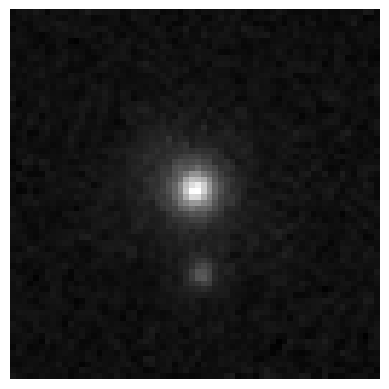

In [26]:
import numpy as np
import matplotlib.pyplot as plt

## LR

# Load the image
img = np.load("/kaggle/input/gsoc-dataset-3b/Dataset/LR/LR_127.npy")
print(img.shape)
# Convert from (C, H, W) to (H, W, C)
img = np.transpose(img, (1, 2, 0))  

# Display the image
plt.imshow(img, cmap="gray")  # Use cmap="gray" if it's a grayscale image
plt.axis("off")  # Hide axes
plt.show()

## Configurations

In [27]:
import torch

class CFG:
    def __init__(self):
        self.lr_folder = "/kaggle/input/gsoc-dataset-3b/Dataset/LR"
        self.hr_folder = "/kaggle/input/gsoc-dataset-3b/Dataset/HR"
        self.batch_size = 64
        self.val_batch_size = 16
        self.num_workers = 4
        self.train_size = 0.9
        
        self.model_d = 56
        self.model_s = 12
        self.model_m = 4

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lr_init = 0.001
        self.epochs = 100
        self.L1_loss_weightage = 0.5
        self.perceptual_loss_model = "densenet169"
        self.perceptual_loss_model_wts = "/kaggle/input/densenet169-best/pytorch/default/1/densenet169_best.pth"
        self.base_model = "/kaggle/input/fsrcnn-base-model/pytorch/default/1/best_fsrcnn_model_best.pth"
        self.weights_fn = "best_modified_fsrcnn_model.pth"

config = CFG()

## Data Preparation

In [28]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import yaml
import argparse
import random
import torchvision.transforms as transforms

class CustomNPYDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, set_type, train_size):
        self.lr_folder = lr_folder
        self.hr_folder = hr_folder
        # self.augment = augment
        self.hr_image_fns = sorted([f for f in os.listdir(hr_folder) if f.endswith(".npy")],
                                key=lambda x: int((x.split(".")[0]).split("_")[1]))
        self.lr_image_fns = sorted([f for f in os.listdir(lr_folder) if f.endswith(".npy")],
                                key=lambda x: int((x.split(".")[0]).split("_")[1]))
        
        # Split the dataset based on set_type (train, val)
        if set_type == "train":
            self.hr_image_fns = self.hr_image_fns[:int(len(self.hr_image_fns) * train_size)]
            self.lr_image_fns = self.lr_image_fns[:int(len(self.lr_image_fns) * train_size)]
        else:  # for validation
            self.hr_image_fns = self.hr_image_fns[int(len(self.hr_image_fns) * train_size):]
            self.lr_image_fns = self.lr_image_fns[int(len(self.lr_image_fns) * train_size):]

        # # Define augmentation transforms
        # self.transform = transforms.Compose([
        #     transforms.RandomHorizontalFlip(p=0.5),
        #     transforms.RandomVerticalFlip(p=0.5),
        #     transforms.RandomRotation(degrees=(0, 270)),
        #     transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x) if random.random() < 0.3 else x),
        # ])

    def __len__(self):
        return len(self.hr_image_fns)

    def __getitem__(self, idx):
        hr_image_fn = self.hr_image_fns[idx]
        lr_image_fn = self.lr_image_fns[idx]
        lr_image = np.load(os.path.join(self.lr_folder, lr_image_fn))
        hr_image = np.load(os.path.join(self.hr_folder, hr_image_fn))

        # Normalize to float32 and convert to tensors
        lr_image = torch.tensor(lr_image, dtype=torch.float32) / 255.0
        hr_image = torch.tensor(hr_image, dtype=torch.float32) / 255.0

        # # Apply augmentations if enabled
        # if self.augment:
        #     lr_image = self.transform(lr_image)
        #     hr_image = self.transform(hr_image)
        
        return lr_image, hr_image


## Model

In [29]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.res_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        return x + self.res_block(x)  # Residual connection

class Modified_FSRCNN(nn.Module):
    def __init__(self, base_model_path, d, s, m):
        super(Modified_FSRCNN, self).__init__()
        
        # Load pre-trained FSRCNN model
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=5, padding=2),
            nn.PReLU()
        )
        self.shrinking = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU()
        )
        
        # Adding residual blocks within the mapping layers
        self.mapping = nn.Sequential(
            *[ResidualBlock(s) for _ in range(m)]
        )
        
        self.expanding = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU()
        )
        self.deconv = nn.ConvTranspose2d(d, 1, kernel_size=9, stride=2, padding=4, output_padding=1)
        
        # Load pre-trained weights into relevant layers
        pretrained_dict = torch.load(base_model_path, weights_only=True)
        model_dict = self.state_dict()
        
        # Only load matching keys
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        
        # # Freeze feature extraction & shrinking layers
        # for param in self.feature_extraction.parameters():
        #     param.requires_grad = False
        
        # for param in self.shrinking.parameters():
        #     param.requires_grad = False
    
    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrinking(x)
        x = self.mapping(x)  # Residual blocks inside mapping
        x = self.expanding(x)
        x = self.deconv(x)
        return x


### Testing Model

In [30]:
# Test with a low-resolution image
lr_images = torch.randn(1, 1, 64, 64)  # Simulating a batch of 1 LR image
testing_model = Modified_FSRCNN(base_model_path=config.base_model, d=config.model_d, s=config.model_s, m=config.model_m)
testing_outputs = testing_model(lr_images)
print("LR Image Shape:", lr_images.shape)    # (1, 1, 75, 75)
print("Model Output Shape:", testing_outputs.shape)  # (1, 1, 128, 128) ✅

LR Image Shape: torch.Size([1, 1, 64, 64])
Model Output Shape: torch.Size([1, 1, 128, 128])


## Loss function

In [31]:
import timm
import torch
import torch.nn as nn
import torchvision.models as models
# Perceptual model class
class DenseNetModel(nn.Module):
    def __init__(self, model_name=config.perceptual_loss_model, pretrained=False):
        super().__init__()
        self.model_name = model_name
        self.pretrained = pretrained
        self.model = timm.create_model(self.model_name, pretrained=self.pretrained, in_chans=1)
        clsf = self.model.default_cfg['classifier']
        self.model._modules[clsf] = nn.Identity()
        
    def forward(self, x):
        x = self.model(x)
        return x

class CustomLoss(nn.Module):
    def __init__(self, perceptual_model_path, device=config.device):
        super(CustomLoss, self).__init__()
        self.densenet = DenseNetModel()
        checkpoint = torch.load(perceptual_model_path)
        self.densenet.load_state_dict(checkpoint["model"], strict=False)
        self.densenet.to(device)
        
        # Freeze DenseNet weights
        for param in self.densenet.parameters():
            param.requires_grad = False
        self.densenet.eval()
        
        # L1 loss for pixel-wise comparison
        self.l1 = nn.L1Loss()

    def forward(self, pred, target, alpha=config.L1_loss_weightage):
        densenet_pred = self.densenet(pred)
        densenet_target = self.densenet(target)
        
        perceptual_loss = self.l1(densenet_pred, densenet_target)
        pixel_loss = self.l1(pred, target)
        
        return perceptual_loss, pixel_loss, ((perceptual_loss / 2) * (1 - alpha)) + (pixel_loss * alpha)

### Testing Loss function

In [32]:
hr_images = torch.randn(1, 1, 128, 128).to(config.device)  # Simulating a batch of 1 HR image
testing_criterion = CustomLoss(config.perceptual_loss_model_wts)
perceptual_loss, pixel_loss, testing_loss = testing_criterion(testing_outputs.to(config.device), hr_images)
print("perceptual loss: ", perceptual_loss.item(), " and pixel loss: ", pixel_loss.item())
print(testing_loss.item())

perceptual loss:  4.339584827423096  and pixel loss:  3.8501224517822266
3.0099573135375977


## Training

In [33]:
import os
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def visualize_predictions(config, model, dataset, device, num_images=10):
    """Displays predicted vs actual HR images for a given dataset."""
    
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # Process one image at a time for visualization
        shuffle=True,  # Randomly pick images
        num_workers=config.num_workers
    )

    model.eval()
    
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 2))
    axes[0, 0].set_title("LR Image")
    axes[0, 1].set_title("Predicted HR Image")
    axes[0, 2].set_title("Actual HR Image")

    with torch.no_grad():
        for i, (lr_images, hr_images) in enumerate(dataloader):
            if i >= num_images:  
                break  # Stop after visualizing `num_images`

            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Model prediction
            outputs = model(lr_images)

            # Convert tensors to numpy
            lr_np = lr_images.cpu().squeeze().numpy()
            pred_hr_np = outputs.cpu().squeeze().numpy()
            hr_np = hr_images.cpu().squeeze().numpy()

            # Plot images
            axes[i, 0].imshow(lr_np, cmap="gray")  # LR Image
            axes[i, 1].imshow(pred_hr_np, cmap="gray")  # Predicted HR Image
            axes[i, 2].imshow(hr_np, cmap="gray")  # Ground Truth HR Image

            for j in range(3):
                axes[i, j].axis("off")  # Remove axes

    plt.tight_layout()
    plt.show()

def train(config, train_loss_list, val_loss_list):
    # Dataset and DataLoader
    train_dataset = CustomNPYDataset(
        lr_folder=config.lr_folder,
        hr_folder=config.hr_folder,
        set_type="train",
        train_size=config.train_size
    )
    val_dataset = CustomNPYDataset(
        lr_folder=config.lr_folder,
        hr_folder=config.hr_folder,
        set_type="val",
        train_size=config.train_size
    )

    print("Train Size: ", (len(train_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")
    print("Validation Size: ", (len(val_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.val_batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )

    # Model
    model = Modified_FSRCNN(base_model_path=config.base_model, d=config.model_d, s=config.model_s, m=config.model_m)
    device = config.device
    model = model.to(device)

    # Loss and Optimizer
    criterion = CustomLoss(config.perceptual_loss_model_wts)
    # criterion = VGGPerceptualLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr_init)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=20, min_lr=1e-6, verbose=True
    )

    # Training Loop
    best_val_loss = float("inf")
    for epoch in range(config.epochs):
        print(f"Epoch {epoch + 1}/{config.epochs}")
        model.train()
        train_loss = 0.0
        train_perceptual_loss = 0.0
        train_pixel_loss = 0.0

        for lr_images, hr_images in tqdm(train_loader, desc="Training"):
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Forward pass
            outputs = model(lr_images)
            perceptual_loss, pixel_loss, loss = criterion(outputs, hr_images)
            # loss = criterion(outputs, hr_images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_perceptual_loss += perceptual_loss.item()
            train_pixel_loss += pixel_loss.item()

        train_loss /= len(train_loader)
        train_perceptual_loss /= len(train_loader)
        train_pixel_loss /= len(train_loader)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for lr_images, hr_images in tqdm(val_loader, desc="Validation"):
                lr_images, hr_images = lr_images.to(device), hr_images.to(device)

                # Forward pass
                outputs = model(lr_images)
                _,_,loss = criterion(outputs, hr_images)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        print("train perceptual loss: ", train_perceptual_loss, " and train pixel loss: ", train_pixel_loss)
        print(f"Training Loss: {train_loss:.6f} and", f"Validation Loss: {val_loss:.6f}")

        # Checkpoint and Learning Rate Scheduler
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), config.weights_fn)
            print(f"Saved Best Model to {config.weights_fn}")

        if (epoch+1) % 10 == 0:
            print("Img of Validation:")
            visualize_predictions(config, model, val_dataset, device, num_images=2)
            print("Img of Training:")
            visualize_predictions(config, model, train_dataset, device, num_images=2)
            

        print("-" * 50)

Train Size:  90.0 %
Validation Size:  10.0 %
Epoch 1/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


train perceptual loss:  0.23653390109539033  and train pixel loss:  0.10445892661809922
Training Loss: 0.111363 and Validation Loss: 0.053008
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 2/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


train perceptual loss:  0.03158145505003631  and train pixel loss:  0.062090645730495456
Training Loss: 0.038941 and Validation Loss: 0.012062
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 3/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


train perceptual loss:  0.00953982789069414  and train pixel loss:  0.024929158762097357
Training Loss: 0.014850 and Validation Loss: 0.014488
--------------------------------------------------
Epoch 4/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]


train perceptual loss:  0.0031922490801662208  and train pixel loss:  0.0272774588316679
Training Loss: 0.014437 and Validation Loss: 0.011729
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 5/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


train perceptual loss:  0.002879824209958315  and train pixel loss:  0.01886383630335331
Training Loss: 0.010152 and Validation Loss: 0.009731
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 6/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.16it/s]


train perceptual loss:  0.002960911067202687  and train pixel loss:  0.01581193283200264
Training Loss: 0.008646 and Validation Loss: 0.005776
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 7/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


train perceptual loss:  0.0029770591296255588  and train pixel loss:  0.008113429602235555
Training Loss: 0.004801 and Validation Loss: 0.004120
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 8/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


train perceptual loss:  0.002906474284827709  and train pixel loss:  0.005128315556794405
Training Loss: 0.003291 and Validation Loss: 0.002727
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 9/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


train perceptual loss:  0.0028536622412502766  and train pixel loss:  0.0038318902719765902
Training Loss: 0.002629 and Validation Loss: 0.002541
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 10/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]

train perceptual loss:  0.0028239114675670863  and train pixel loss:  0.0034220936708152295
Training Loss: 0.002417 and Validation Loss: 0.002220
Saved Best Model to best_modified_fsrcnn_model.pth
Img of Validation:


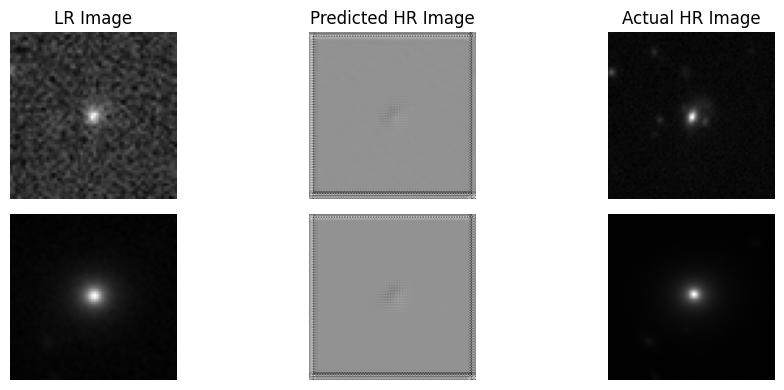

Img of Training:


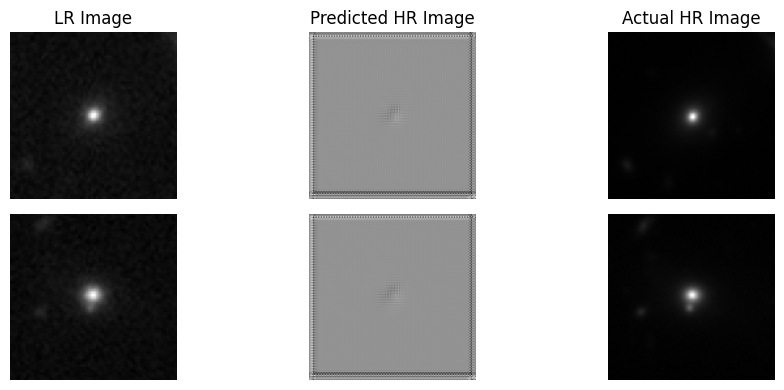

--------------------------------------------------
Epoch 11/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]


train perceptual loss:  0.002727390453219414  and train pixel loss:  0.0025743740145117043
Training Loss: 0.001969 and Validation Loss: 0.001774
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 12/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.21it/s]


train perceptual loss:  0.0025849351193755867  and train pixel loss:  0.002321515465155244
Training Loss: 0.001807 and Validation Loss: 0.001763
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 13/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.34it/s]


train perceptual loss:  0.002408825559541583  and train pixel loss:  0.002063141390681267
Training Loss: 0.001634 and Validation Loss: 0.001506
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 14/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


train perceptual loss:  0.0020885942270979286  and train pixel loss:  0.0018961207941174507
Training Loss: 0.001470 and Validation Loss: 0.001407
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 15/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


train perceptual loss:  0.0017138970782980324  and train pixel loss:  0.0018290603067725897
Training Loss: 0.001343 and Validation Loss: 0.001256
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 16/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]


train perceptual loss:  0.0012926813447847962  and train pixel loss:  0.0017882261192426086
Training Loss: 0.001217 and Validation Loss: 0.001267
--------------------------------------------------
Epoch 17/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


train perceptual loss:  0.0010288328863680362  and train pixel loss:  0.0016828567488119007
Training Loss: 0.001099 and Validation Loss: 0.001041
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 18/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


train perceptual loss:  0.0009057429269887507  and train pixel loss:  0.001531373430043459
Training Loss: 0.000992 and Validation Loss: 0.000955
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 19/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


train perceptual loss:  0.0007348401937633753  and train pixel loss:  0.0014587926445528865
Training Loss: 0.000913 and Validation Loss: 0.000862
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 20/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

train perceptual loss:  0.0005159941618330776  and train pixel loss:  0.0013663613935932517
Training Loss: 0.000812 and Validation Loss: 0.000752
Saved Best Model to best_modified_fsrcnn_model.pth
Img of Validation:


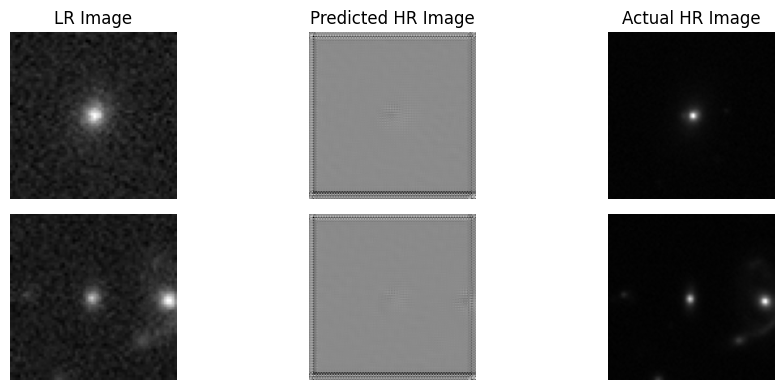

Img of Training:


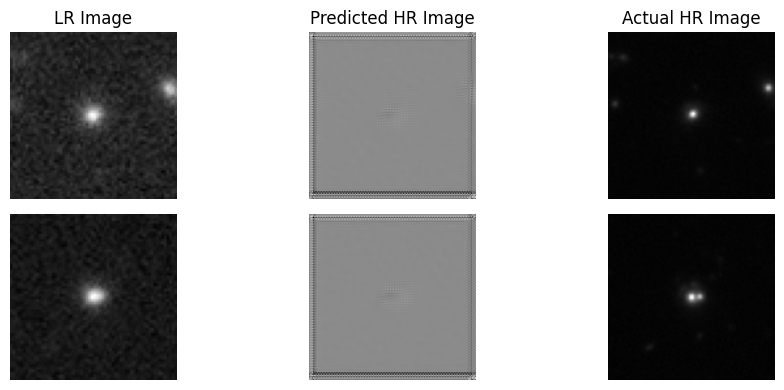

--------------------------------------------------
Epoch 21/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


train perceptual loss:  0.0004147665633354336  and train pixel loss:  0.0012506620492786168
Training Loss: 0.000729 and Validation Loss: 0.000738
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 22/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


train perceptual loss:  0.0003789339796639979  and train pixel loss:  0.0011487495619803667
Training Loss: 0.000669 and Validation Loss: 0.000639
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 23/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


train perceptual loss:  0.0003067225741688162  and train pixel loss:  0.001095450366847217
Training Loss: 0.000624 and Validation Loss: 0.000613
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 24/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


train perceptual loss:  0.0002717622264754027  and train pixel loss:  0.0010381038766354323
Training Loss: 0.000587 and Validation Loss: 0.000597
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 25/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]


train perceptual loss:  0.0002142076613381505  and train pixel loss:  0.0010008814511820673
Training Loss: 0.000554 and Validation Loss: 0.000513
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 26/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


train perceptual loss:  0.0001672607468208298  and train pixel loss:  0.0009811687865294515
Training Loss: 0.000532 and Validation Loss: 0.000492
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 27/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]


train perceptual loss:  0.0001470416085794568  and train pixel loss:  0.0009446108364500105
Training Loss: 0.000509 and Validation Loss: 0.000471
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 28/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]


train perceptual loss:  0.00013099656935082747  and train pixel loss:  0.0009062815806828439
Training Loss: 0.000486 and Validation Loss: 0.000555
--------------------------------------------------
Epoch 29/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


train perceptual loss:  0.0001097630156436935  and train pixel loss:  0.0008717033895663917
Training Loss: 0.000463 and Validation Loss: 0.000511
--------------------------------------------------
Epoch 30/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.38it/s]

train perceptual loss:  9.774852806003765e-05  and train pixel loss:  0.0008496460621245205
Training Loss: 0.000449 and Validation Loss: 0.000486
Img of Validation:


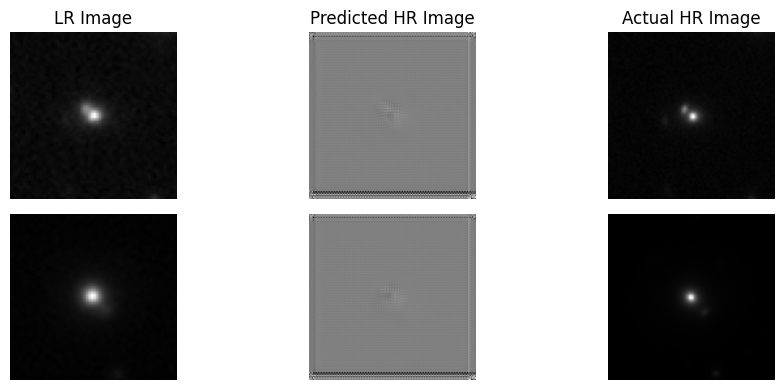

Img of Training:


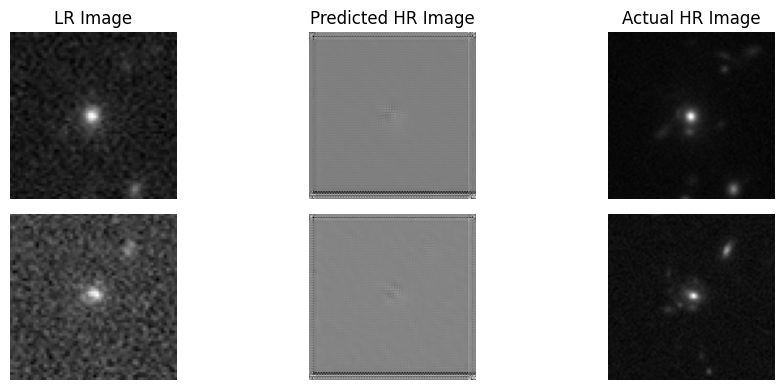

--------------------------------------------------
Epoch 31/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]


train perceptual loss:  9.742975962581112e-05  and train pixel loss:  0.0008419868885539472
Training Loss: 0.000445 and Validation Loss: 0.000405
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 32/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]


train perceptual loss:  8.939021063270047e-05  and train pixel loss:  0.0007736103725619614
Training Loss: 0.000409 and Validation Loss: 0.000372
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 33/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


train perceptual loss:  8.533151703886688e-05  and train pixel loss:  0.000736210762988776
Training Loss: 0.000389 and Validation Loss: 0.000367
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 34/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


train perceptual loss:  8.339523774338886e-05  and train pixel loss:  0.0007094601285643875
Training Loss: 0.000376 and Validation Loss: 0.000350
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 35/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]


train perceptual loss:  7.791742100380362e-05  and train pixel loss:  0.0006783737218938768
Training Loss: 0.000359 and Validation Loss: 0.000344
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 36/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


train perceptual loss:  7.614644709974527e-05  and train pixel loss:  0.0006603706628084183
Training Loss: 0.000349 and Validation Loss: 0.000322
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 37/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


train perceptual loss:  6.859240747871808e-05  and train pixel loss:  0.0006392153329215944
Training Loss: 0.000337 and Validation Loss: 0.000337
--------------------------------------------------
Epoch 38/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.40it/s]


train perceptual loss:  6.945218483451754e-05  and train pixel loss:  0.0006305540096946061
Training Loss: 0.000333 and Validation Loss: 0.000341
--------------------------------------------------
Epoch 39/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]


train perceptual loss:  6.830011552665383e-05  and train pixel loss:  0.0006148625165224075
Training Loss: 0.000325 and Validation Loss: 0.000322
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 40/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

train perceptual loss:  6.508479418698698e-05  and train pixel loss:  0.00057674233103171
Training Loss: 0.000305 and Validation Loss: 0.000288
Saved Best Model to best_modified_fsrcnn_model.pth
Img of Validation:


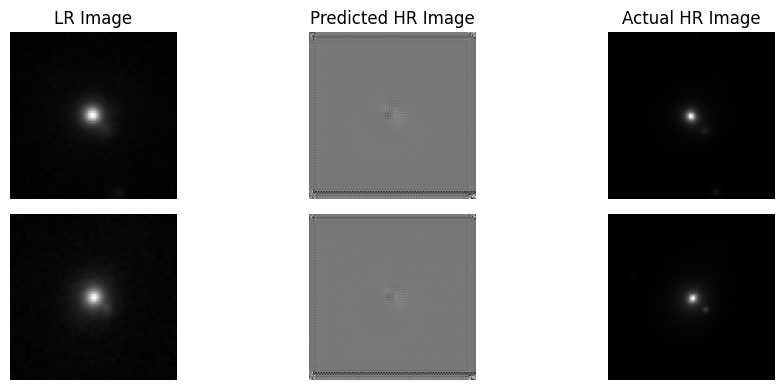

Img of Training:


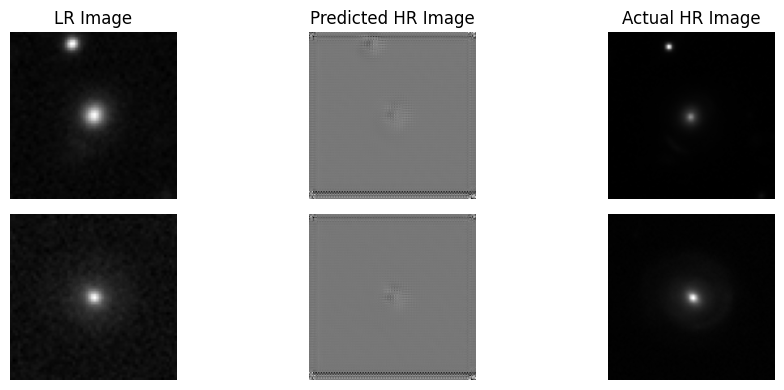

--------------------------------------------------
Epoch 41/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


train perceptual loss:  6.234072934603318e-05  and train pixel loss:  0.0005558494129218161
Training Loss: 0.000294 and Validation Loss: 0.000312
--------------------------------------------------
Epoch 42/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


train perceptual loss:  6.3291571859736e-05  and train pixel loss:  0.000553956045769155
Training Loss: 0.000293 and Validation Loss: 0.000307
--------------------------------------------------
Epoch 43/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


train perceptual loss:  5.998581400490366e-05  and train pixel loss:  0.00052417719271034
Training Loss: 0.000277 and Validation Loss: 0.000273
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 44/100


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


train perceptual loss:  6.194716261234134e-05  and train pixel loss:  0.0005029630963690579
Training Loss: 0.000267 and Validation Loss: 0.000250
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 45/100


Training:  20%|██        | 1/5 [00:00<00:02,  1.64it/s]


KeyboardInterrupt: 

In [34]:
import warnings

if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    train_loss_list = []
    val_loss_list = []
    train(config, train_loss_list, val_loss_list)

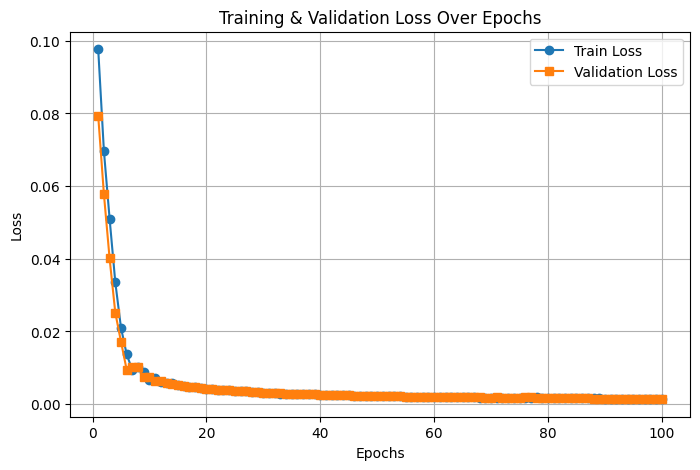

In [9]:
import matplotlib.pyplot as plt

def plot_loss(train_loss_list, val_loss_list):
    epochs = range(1, len(train_loss_list) + 1)  # X-axis: Epochs

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss_list, label="Train Loss", marker="o", linestyle="-")
    plt.plot(epochs, val_loss_list, label="Validation Loss", marker="s", linestyle="-")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this function after training
plot_loss(train_loss_list, val_loss_list)

## Evaluation Metrics

In [12]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm
import torch.nn.functional as F

def evaluate_metrics(config, model, dataset, device, dataset_name="Train"):
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # SSIM, PSNR, and MSE are calculated per image
        shuffle=False,
        num_workers=config.num_workers
    )

    ssim_scores = []
    psnr_scores = []
    mse_scores = []  # Added MSE storage

    model.eval()
    with torch.no_grad():
        for lr_images, hr_images in tqdm(dataloader, desc=f"Evaluating {dataset_name} Dataset"):
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Model prediction
            outputs = model(lr_images)

            # Convert tensors to numpy arrays
            hr_np = hr_images.cpu().squeeze().numpy()
            out_np = outputs.cpu().squeeze().numpy()

            # Compute SSIM and PSNR
            ssim_value = ssim(hr_np, out_np, data_range=out_np.max() - out_np.min())
            psnr_value = psnr(hr_np, out_np, data_range=out_np.max() - out_np.min())

            # Compute MSE
            mse_value = F.mse_loss(outputs, hr_images).item()  # Using PyTorch MSE

            ssim_scores.append(ssim_value)
            psnr_scores.append(psnr_value)
            mse_scores.append(mse_value)  # Store MSE

    # Compute average SSIM, PSNR, and MSE
    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)
    avg_mse = np.mean(mse_scores)  # Compute average MSE

    print(f"Average SSIM for {dataset_name} Dataset: {avg_ssim:.4f}")
    print(f"Average PSNR for {dataset_name} Dataset: {avg_psnr:.4f} dB")
    print(f"Average MSE for {dataset_name} Dataset: {avg_mse:.9f}")  # Print MSE with 9 decimals
    print("-" * 50)
    
    return avg_ssim, avg_psnr, avg_mse

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Modified_FSRCNN(base_model_path=config.base_model, d=config.model_d, s=config.model_s, m=config.model_m).to(device)
model.load_state_dict(torch.load(config.weights_fn))
model.eval()

train_dataset = CustomNPYDataset(
    lr_folder=config.lr_folder,
    hr_folder=config.hr_folder,
    set_type="train",
    train_size=config.train_size
)
val_dataset = CustomNPYDataset(
    lr_folder=config.lr_folder,
    hr_folder=config.hr_folder,
    set_type="val",
    train_size=config.train_size
)

print("Train Size: ", (len(train_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")
print("Validation Size: ", (len(val_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")

# Evaluate Train and Validation datasets (Now Includes MSE)
train_ssim, train_psnr, train_mse = evaluate_metrics(config, model, train_dataset, device, "Train")
val_ssim, val_psnr, val_mse = evaluate_metrics(config, model, val_dataset, device, "Validation")


Train Size:  90.0 %
Validation Size:  10.0 %


Evaluating Train Dataset: 100%|██████████| 270/270 [00:01<00:00, 169.49it/s]


Average SSIM for Train Dataset: 0.0053
Average PSNR for Train Dataset: 14.1622 dB
Average MSE for Train Dataset: 0.005202416
--------------------------------------------------


Evaluating Validation Dataset: 100%|██████████| 30/30 [00:00<00:00, 105.50it/s]

Average SSIM for Validation Dataset: 0.0067
Average PSNR for Validation Dataset: 15.1378 dB
Average MSE for Validation Dataset: 0.004569379
--------------------------------------------------


In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

def visualize_predictions(config, model, dataset, device, num_images=10):
    """Displays predicted vs actual HR images for a given dataset."""
    
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # Process one image at a time for visualization
        shuffle=True,  # Randomly pick images
        num_workers=config.num_workers
    )

    model.eval()
    
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 2))
    axes[0, 0].set_title("LR Image")
    axes[0, 1].set_title("Predicted HR Image")
    axes[0, 2].set_title("Actual HR Image")

    with torch.no_grad():
        for i, (lr_images, hr_images) in enumerate(dataloader):
            if i >= num_images:  
                break  # Stop after visualizing `num_images`

            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Model prediction
            outputs = model(lr_images)

            # Convert tensors to numpy
            lr_np = lr_images.cpu().squeeze().numpy()
            pred_hr_np = outputs.cpu().squeeze().numpy()
            hr_np = hr_images.cpu().squeeze().numpy()

            # Plot images
            axes[i, 0].imshow(lr_np, cmap="gray")  # LR Image
            axes[i, 1].imshow(pred_hr_np, cmap="gray")  # Predicted HR Image
            axes[i, 2].imshow(hr_np, cmap="gray")  # Ground Truth HR Image

            for j in range(3):
                axes[i, j].axis("off")  # Remove axes

    plt.tight_layout()
    plt.show()

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Modified_FSRCNN(base_model_path=config.base_model, d=config.model_d, s=config.model_s, m=config.model_m).to(device)
model.load_state_dict(torch.load(config.weights_fn))
model.eval()

# Call function to visualize predictions
visualize_predictions(config, model, val_dataset, device, num_images=10)
